# [Chapter 11] Cleaning the Online Shopping data

## **[DSLC stages]**: Data cleaning and pre-processing





## Domain problem formulation


Our goal for this project is to develop a predictive algorithm for predicting the purchase intent of user sessions on an e-commerce website. Our intention is to use the algorithm we develop to predict which use sessions to the same e-commerce site are likely to end in a purchase in the years immediately following the data period.


## Data source overview


The *Online Shoppers Purchasing Intention* dataset was collected by Sakar et al. and can be downloaded from the [UCI Machine Learning repository](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset).



In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100



## Step 1: Review background information


### Information on data collection 


We unfortunately don't know a whole lot about how the data were collected. All that we do know is from the [UCI Machine Learning repository]((https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#)) itself and the paper written by Sakar et al.'s 2009 [paper](https://link.springer.com/article/10.1007/s00521-018-3523-0) titled 'Real-time prediction of online shoppers' purchasing intention using multilayer perceptron and LSTM recurrent neural networks'. 


### Data dictionary

The features (in terms of the cleaned columns names) for each user session include a set of variables describing the number and type of pages each user visited in their session, and the amount of time they spend on each type of page:

- `Administrative`: the number of administrative-type pages that the user visited during the session.

- `Administrative_Duration`: the length of time (in seconds) that the user spent on administrative pages during their session.

- `Informational`: the number of informational-type pages that the user visited during the session.

- `Informational_Duration`: the length of time (in seconds) that the user spent on informational pages during their session.

- `ProductRelated`: the number of product-related-type pages that the user visited during the session.

- `ProductRelated_Duration`: the length of time (in seconds) that the user spent on product-related pages during their session.

Next, there are a set of features collected from Google Analytics. 

- `BounceRates`: the average bounce rate value of the pages visited during the session. For a specific web page, the *bounce rate* is the percentage of users who enter the site from that page and then leave ('bounce') without triggering any other requests to the analytics server during their session.

- `ExitRates`:  the average exit rate value of the pages visited during the session. For a specific web page, the *exit rate* is the proportion of page views to the page, that were the last in the session. 

- `PageValues`: the average page value of the pages visited during the session. The *page value* for a web page gives an idea of how much each page contributes to the site's revenue. 

- `OperatingSystems`: the operating system that the user was using for the session. The operating systems are coded as integers.

- `Browser`: the web browser that the user was using for the session. The browsers are coded as integers.

- `Region`: the geographic region in which the user is located for their session. The regions are coded as integers.

- `TrafficType`: the source of the referral for the session (how did the user arrive at the site?), examples include an advertisement banner, an SMS link, direct URL. The traffic types are coded as integers.

- `VisitorType`: a categorical variable that specifies whether the session corresponded to a `"New_Visitor"`, a `"Returning_Visitor"`, or `"Other"` (whatever "other" means). 

Then there are also several features corresponding to the date.

- `SpecialDay`: a numeric value between 0 and 1 indicating how closeness the site visiting time is to a "special day" (such as Mother's day, Valentine's day), in which the sessions are - hypothetically - more likely to be finalized with a transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentine’s day, `special_day` takes a nonzero value between February 2 and February 12, achieving the maximum value of 1 on February 8 (6 days before Valentine's day).

- `Month`: the month in which the session took place.

- `Weekend`: a binary variable corresponding to whether the session occurred on a weekend or a weekday.

Finally, there is the response variable that we are interested in predicting:

- `Revenue`: the **response variable** corresponding to whether a purchase was made during the session. (We will change the name of this feature to `purchase` below.)



### Answering questions about the background information

In this section, we will go through the recommended background information questions from the Data Cleaning chapter.

- *What does each variable measure?* Most of the information in the data dictionary is fairly self-explanatory. We did some Googling to understand the Google Analytics variables, many of which involve aggregate measurements across many all sessions (which was confusing because they are different numbers for each session). It turns out that each page has an associated "bounce rate', for example, and an individual *session's* bounce rate corresponds to the *average* bounce rate across *all pages* that were visited in the session (similarly for the 'exit rate' and "page values" etc). Some useful information can be found [here](https://support.google.com/analytics/answer/2695658?hl=en&ref_topic=6156780).

- *How was the data collected?* We unfortunately don't have a whole lot of information about where the data came from, and which online shop it corresponds to. (We emailed the authors of the data requesting additional background information and did not hear back.)

- *What are the observational units?* The observational units are the individual user sessions.

- *Is the data relevant to my project?* Since we defined our project goal narrowly as generating predictions for sessions to the same e-commerce store in the years immediately following the period covered by the data, the data is relevant to our project. But since we know so little about the data and even what type of e-commerce store it corresponds to, the data is not particularly relevant outside of this very narrow scope. 



## Step 2: Loading the data

Fortunately the data consists of only one single `.csv` file, so loading it is very easy:


In [2]:
shopping_orig = pd.read_csv('../data/online_shoppers_intention.csv')

Let's look at the first few rows to make sure it looks like it has been loaded in correctly:


In [3]:
shopping_orig.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False



It looks like the data is in a reasonable format, but we already notice something strange: the third entry has negative entries for the `Administrative_Duration`, `Informational_Duration`, and `ProductRelated_Duration`  features (how can a duration be negative?).  Let's make a note to check this out (we will certainly cover it in our invalid values explorations)!


> **Question: Why are there negative "duration" entries?**
>
> Ensure that the data only contains `Sale Condition == "Normal"` and `MS.Zoning` is not equal to any of `"A (agr)", "C (all)", "I (all)"`




And let's examine the dimension of the data. 


In [4]:
shopping_orig.shape

(12330, 18)


This matches what is written on the UCI Machine Learning repository. 




### Filtering to the relevant portion of the data

As far as we are concerned, all of the data are relevant. 



## Step 3: Examine the data

In this section we explore the common messy data traits to identify any cleaning action items.




### Invalid values

Recall from above that there were some surprising negative values in the `_Duration` features. Let's see if this reoccurs in some randomly selected rows of the data. 


In [5]:
shopping_orig.sample(10, random_state=344)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
7213,0.0,0.000000,0.0,0.0,29.0,2064.766667,0.020690,0.037356,0.000000,0.0,June,2,4,3,1,Returning_Visitor,False,False
10111,0.0,0.000000,0.0,0.0,4.0,478.033333,0.050000,0.047619,0.000000,0.0,Nov,1,1,3,2,Returning_Visitor,True,False
9494,0.0,0.000000,0.0,0.0,1.0,0.000000,0.200000,0.200000,0.000000,0.0,Dec,2,2,1,3,Returning_Visitor,False,False
6614,0.0,0.000000,0.0,0.0,55.0,1023.506667,0.000000,0.009091,45.711463,0.0,Aug,2,2,1,4,Returning_Visitor,False,True
2181,7.0,150.500000,0.0,0.0,28.0,549.083333,0.000000,0.013571,2.663333,0.0,May,1,1,1,2,Returning_Visitor,False,True
8287,4.0,643.833333,0.0,0.0,17.0,508.250000,0.031579,0.052632,0.000000,0.0,Nov,2,4,1,1,Returning_Visitor,False,False
6137,1.0,38.200000,0.0,0.0,24.0,1282.953333,0.034783,0.049565,0.000000,0.0,Nov,2,2,4,1,Returning_Visitor,True,False
9988,0.0,0.000000,0.0,0.0,13.0,1314.083333,0.000000,0.008333,103.061083,0.0,Dec,8,13,9,20,Other,False,True
3001,4.0,56.666667,0.0,0.0,21.0,797.295238,0.000000,0.019876,0.000000,0.0,May,1,1,3,2,Returning_Visitor,False,False
8414,0.0,0.000000,0.0,0.0,8.0,64.000000,0.000000,0.050000,0.000000,0.0,Dec,2,2,3,8,New_Visitor,False,False



Nothing in this sample seems odd so far.  Let's do some explorations of the individual variables. 



#### Numeric variables


To explore the validity of the values in the numeric variables, we will first look at the min, max, and mean for each column. The only variables that seem to have surprising max/min values is the `_Duration` variables, which we already noticed.

In [6]:
shopping_orig.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000



It is also clear that there are several variables that would be much better coded as categorical (such as `OperatingSystems`, `Browser`, etc), but we will handle that when we address the variable formats below. 



To see how prevalent these negative duration values are, we can count the number of negative durations that occur:


In [7]:
shopping_orig[['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']].apply(lambda x: sum(x < 0))

Administrative_Duration    33
Informational_Duration     33
ProductRelated_Duration    33
dtype: int64


It seems that there are 33 sessions with negative durations in the entire dataset (this is less than 0.3% of all sessions). Notice also that when there is a negative duration for one of the three duration variables, the other two are also negative.


In [8]:
shopping_orig[['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']].query('Administrative_Duration < 0')

,Administrative_Duration,Informational_Duration,ProductRelated_Duration
2,-1.0,-1.0,-1.0
6,-1.0,-1.0,-1.0
7,-1.0,-1.0,-1.0
16,-1.0,-1.0,-1.0
21,-1.0,-1.0,-1.0
24,-1.0,-1.0,-1.0
49,-1.0,-1.0,-1.0
50,-1.0,-1.0,-1.0
64,-1.0,-1.0,-1.0
132,-1.0,-1.0,-1.0



What should we do about these negative values. Since they are so rare, they are unlikely to cause any issues in our algorithm, regardless of whether we leave them as they are, replace them with negative values (to later impute them) or remove the rows entirely. However, so that we are consistent with our definition of clean data (that recommends replacing invalid values with missing values), let's replace them with missing values.

> **Data cleaning: Replace negative duration entries with NA**
>
> Since it doesn't make sense to have a negative duration value, we will replace these negative entries with missing values. Alternative judgment calls include leave them as they are, or removing the rows with negative duration entries (but the other measurements in these rows seem to be reasonable, so we won't recommend this last option).


Looking at the other numeric variables, since it can be hard to tell if the maximums and minimums are reasonable in general, it is often helpful to visualize the distribution of each numeric variable using a histogram:


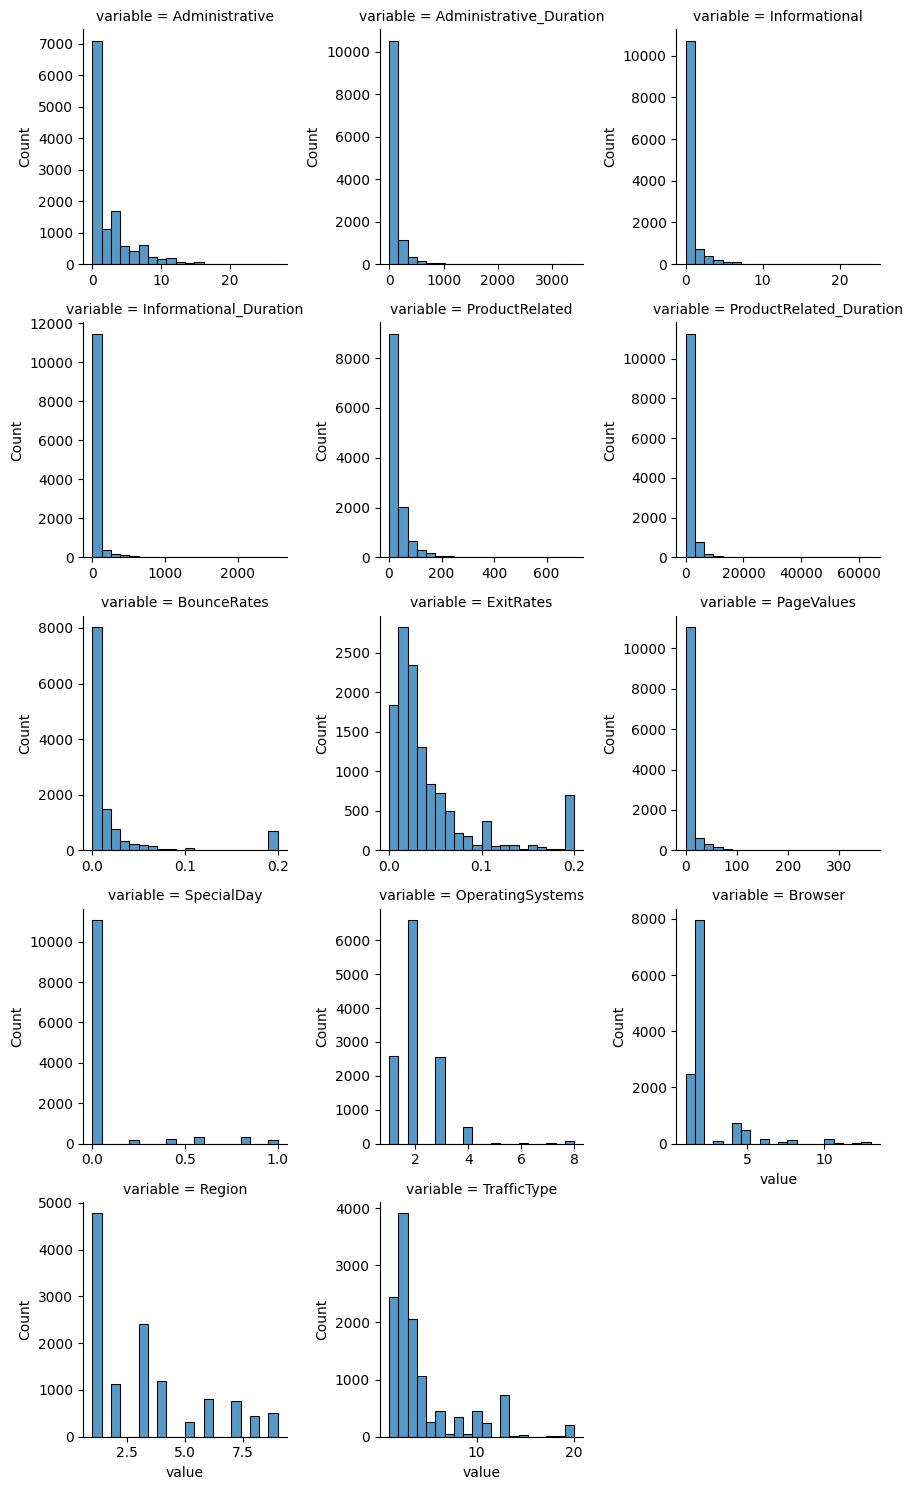

In [9]:
shopping_numeric_long = shopping_orig.select_dtypes(include=['number']).melt()
g = sns.FacetGrid(shopping_numeric_long, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sns.histplot, 'value', bins=20)


Nothing here looks odd (except we note that the `SpecialDay` variable is not a binary variable but takes a value between 0 and 1, apparently to represent the "closeness" to a special day, with most values being equal to 0). 


#### Categorical variables

Next, we will look at the unique values of each categorical value. The following code prints out the unique values for each variable as a list (there are only two variables `Month` and `VisitorType`). 



In [10]:
# show the unique values in each categorical column 
for col in shopping_orig.select_dtypes(include=['object']).columns:
    print(shopping_orig[col].value_counts(), "\n")

Month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64 

VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64 




Notice that there are fewer months than expected. The months of January and April are missing entirely from the data (we looked at the raw data file to confirm that we had not just loaded in the data incorrectly). We could not find an explanation as to why this might be the case, however. 


> **Question: Why are January and April absent from the data?**
> 
> There are no sessions recorded for these months at all. We couldn't find an explanation as to why this is the case.


In addition, we don't know what it means when `VisitorType` is equal to "Other" (how can someone neither be new nor returning?). Since there are so few "Other" `VisitorType` entries, that it would likely be simpler to convert the `VisitorType` variable to a binary variable for whether the visitor is a new visitor or not (where "not" encompasses returning visitor and other). This isn't necessary for the data to be clean, however, so it is a pre-processing step rather than a cleaning step.

> **Pre-processing action item: Convert `VisitorType` to a binary variable that is 1 (new visitor) or 0 (other or returning visitor)**
>
> This is because there are so few "other" entries, it doesn't make sense to create dummy variables for this level (which we will have to do to use this variable in a predictive algorithm that only allows numeric entries). 


Since we plan to convert the `Browser`, `OperatingSystems`, and `TrafficType` variables to categorical formats, let's also take a look at them.


In [11]:
for col in ["Browser", "OperatingSystems", "TrafficType"]:
    print(shopping_orig[[col]].value_counts(), "\n")

Browser
2          7961
1          2462
4           736
5           467
6           174
10          163
8           135
3           105
13           61
7            49
12           10
11            6
9             1
Name: count, dtype: int64 

OperatingSystems
2                   6601
1                   2585
3                   2555
4                    478
8                     79
6                     19
7                      7
5                      6
Name: count, dtype: int64 

TrafficType
2              3913
1              2451
3              2052
4              1069
13              738
10              450
6               444
8               343
5               260
11              247
20              198
9                42
7                40
15               38
19               17
14               13
18               10
16                3
12                1
17                1
Name: count, dtype: int64 





Notice that for each of these variables there are some levels a few very few observations in them. We are thus likely to later run into the issue, e.g., of levels appearing in the validation set but not in the training set. Thus we will add an additional pre-processing step:


> **Pre-processing action item: For all categorical variables for which a level has few observations in it in the original data (using a threshold of 50 observations), combine the rare levels into an "other" category**
> 
> Combine categorical levels with fewer than 50 observations (for the training set) into an "other" category. For the validation and test sets, create the same levels as were created for the training set (rather than using this thresholding rule).


### Missing values

Let's count the proportion of missing values in each column. There are a few rows with missing values, but this amounts to around 14 (0.1% of all) rows, which is very few.

In [12]:
shopping_orig.apply(lambda x: sum(x.isnull()))

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

To decide what to do about these rows, we will check to see if they tend to occur in the same rows:



In [13]:
shopping_orig[shopping_orig["Administrative_Duration"].isnull()]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
1065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,2,1,Returning_Visitor,False,False
1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,1,2,Returning_Visitor,False,False
1133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,4,5,1,Returning_Visitor,False,False
1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,False,False
1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,3,2,1,1,Returning_Visitor,False,False
1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,False,False
1473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,1,Returning_Visitor,True,False
1474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,6,1,Returning_Visitor,True,False
1475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,3,1,Returning_Visitor,False,False
1476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,2,3,Returning_Visitor,False,False



Indeed, it is one set of 14 observations that have missing values for all of these variables. And there is something else interesting too: *they all took place in March.* 

While we don't know this to be the case, there might have been some kind of system failure that briefly occurred leading to the missing values for a few observations. Since so many of the measurements for these observations/rows are missing (and since there are only 14 such rows), rather than imputing them when pre-processing the data, we will opt to instead remove these 14 rows.

> **Pre-processing action item: Remove the 14 rows with missing values**
> 
> Since the 14 rows with missing values are missing values for so many of the variables, and since there are only 14 of them, we decide to remove these rows from the data before training our predictive fits. An alternative judgment call is to impute them with 0, but this is unlikely to matter much since it affects so few rows.




### Data format


The data is already in a "tidy" format, where each row corresponds to the data for a single observational unit, and each column corresponds to a unique type of measurement. 



### Column names

The column names need to be cleaned in order to conform to our tidy column name requirements of words in column names being underscore-separated and lowercase. For instance, we would like to rename `ProductRelated_Duration` to be `product_related_duration`.


> **Data cleaning action item: Clean the column names**
> 
> Rename the columns so that they are consistently formatted, with underscore-separated words and human readable. We will automate this process using the `clean_names()` function from the `janitor` R package.





### Variable type

The code below prints the type of each variable, each of which seems to be a number (integer or float), a text field (object) or boolean.


In [14]:
# print out the type of each column
shopping_orig.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

> **Data cleaning action item: Convert the `OperatingSystems`, `Browser`, `Region`, and `TrafficType` numeric variables to categorical**
>
> Since these variables are obviously supposed to be categorical, we will convert them to a categorical format. However, an alternative judgment call is to leave them in their integer format (which doesn't feel intuitive, but it will be interesting to see how this decision affects predictive performance--perhaps there is some ordering to the entries that we don't know about). 


It also seems intuitive to convert the `Month` variable to a numeric variable, however the categorical option makes sense too. Since it does not feel necessary to convert `Month` to a numeric variable (rather we are curious if it will improve our down-stream predictive performance), we will include it as a pre-processing step, rather than a data cleaning step.

> **Pre-processing action item: Convert the `Month` variable to a numeric type**
>
> Since the month are ordered, it makes sense to convert it to a numeric variable. An alternative judgment call is to keep it as a categorical variable (which will then have to be converted into dummy variables later during pre-processing).


### Incomplete data

Since we don't have a list of all sessions for the e-commerce site, we don't know if the data is complete. Are the sessions from January and April missing because there were none (e.g., maybe the site was down), or are they just missing from the data. Unfortunately without any additional information, there is nothing we can do about this.




## Step 4: Clean and pre-process the data

Now we implement the cleaning and pre-processing action items that we proposed in the sections above. Since the cleaning and pre-processing action items feel very inter-related, we will write a single `prepare_shopping_data()` function, rather writing two separate functions.


The default action items include:

- Clean the column names.

- Replace the negative duration values with `NA`.

- Convert the `OperatingSystems`, `Browser`, `Region`, and `TrafficType` numeric variables to a categorical format.


We also included optional pre-processing action items (as arguments):

- Convert durations from seconds to minutes.

- Convert `VisitorType` to a binary variable that is 1 (new visitor) or 0 (other or returning visitor).

- Adding an option to remove the 14 rows with missing values (alternative judgment call: impute the missing values instead).

- For all categorical variables for which a level has few observations in it in the original data (using a threshold of 50 observations), combine the rare levels into an "other" category.

- Convert the `Month` variable to a numeric type.

- Convert categorical variables to dummy variables.

- Remove the extreme observations with very large numbers of pageviews, that may be bots.

- Applying a log-transformation to several of the predictor variables.



Alternative judgment calls for each of these action items is to *not* implement them.
The cleaning/preprocessing "preparation" function is shown below and is saved in the file "functions/prepare_shopping_data.R". At the end of this file, the data is split into training, validation, and test sets and each dataset is prepared using the `prepare_shopping_data()` function.

In [15]:
def prepare_shopping_data(shopping_data,
                          replace_negative_na=True,
                          numeric_to_cat=True,
                          remove_missing=True,
                          impute_missing=False,
                          durations_to_minutes=True,
                          visitor_binary=True,
                          dummy=True,
                          month_numeric=False,
                          log_page=False,
                          remove_extreme=False,
                          operating_systems_levels=None,
                          browser_levels=None,
                          traffic_type_levels=None,
                          column_selection=None):
    
    shopping = shopping_data.copy()
    
    # change the name of the column "Revenue" to "purchase"
    shopping['purchase'] = shopping['Revenue']
    shopping = shopping.drop(columns=['Revenue'])
    
    # convert weekend to numeric
    shopping['Weekend'] = shopping['Weekend'].astype(int)
    
    # replace negative duration values with NA
    if replace_negative_na:
        shopping[["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]] = shopping[["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]].apply(lambda x: x.where(x >= 0))
    
    # convert operating systems, browser, traffic type and region numeric features to categorical 
    if numeric_to_cat:
        shopping[["OperatingSystems", "Browser", "TrafficType", "Region"]] = shopping[["OperatingSystems", "Browser", "TrafficType", "Region"]].astype(str)
    
    # convert durations to minutes
    if durations_to_minutes:
        shopping[["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]] = shopping[["Administrative_Duration", "Informational_Duration", "ProductRelated_Duration"]].apply(lambda x: x/60)
    
    # convert visitor type to binary numeric (ignoring "other")
    if visitor_binary:
        shopping['VisitorType'] = shopping['VisitorType'].map({'Returning_Visitor': 1, 'New_Visitor': 0})
    
    # remove rows with missing values or impute them with 0
    if remove_missing:
        shopping = shopping.dropna()
    elif impute_missing:
        shopping = shopping.fillna(0)
        
    # combine rare levels of categorical variables
    # match to the provided levels (for validation and test sets)
    # operating systems:
    if operating_systems_levels is not None:
        shopping['OperatingSystems'] = shopping['OperatingSystems'].apply(lambda x: x if x in operating_systems_levels else "Other")
    else:
        # just lump any levels with fewer than 50 occurrences into "Other"
        shopping['OperatingSystems'] = shopping['OperatingSystems'].apply(lambda x: x if shopping['OperatingSystems'].value_counts()[x] >= 50 else "Other")
    # traffic type:
    if traffic_type_levels is not None:
        shopping['TrafficType'] = shopping['TrafficType'].apply(lambda x: x if x in traffic_type_levels else "Other")
    else:
        shopping['TrafficType'] = shopping['TrafficType'].apply(lambda x: x if shopping['TrafficType'].value_counts()[x] >= 50 else "Other")
    # browser:
    if browser_levels is not None:
        shopping['Browser'] = shopping['Browser'].apply(lambda x: x if x in browser_levels else "Other")
    else:
        shopping['Browser'] = shopping['Browser'].apply(lambda x: x if shopping['Browser'].value_counts()[x] >= 50 else "Other")
    
    # convert month to numeric
    if month_numeric:
        shopping['Month'] = shopping['Month'].map({'Feb': 2, 'Mar': 3, 'May': 5, 'June': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12})
    
    # create dummy variables for categorical features (ignoring purchase)
    if dummy:
        shopping = pd.get_dummies(shopping, drop_first=True)
    
    # remove extreme product-related duration observations
    if remove_extreme:
        shopping = shopping[(shopping['ProductRelated_Duration'] < 400) & (shopping['ProductRelated_Duration'] <= 720 * 60)]
        
    # log-transform predictors
    if log_page:
        # log-transform predictors
        if log_page:
            shopping[['Administrative', 'Informational', 'Product_Related', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']] = np.log(shopping[['Administrative', 'Informational', 'Product_Related', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']] + 1)
            shopping[['Exit_Rates']] = np.log(shopping[['Exit_Rates']] + 0.0001)
            shopping[['Bounce_Rates']] = np.log(shopping[['Bounce_Rates']] + 0.00001)
    
    # filter to specified columns (helpful for making val/test sets match training set)
    if column_selection is not None:
        shopping = shopping[column_selection]
    
    # clean column names
    shopping.columns = shopping.columns.str.replace(' ', '_').str.lower()
    shopping.columns = shopping.columns.rename(columns={"productrelated": "product_related", 
                                                        "productrelated_duration": "product_related_duration", 
                                                        "bouncerates": "bounce_rates",
                                                        "exitrates": "exit_rates",
                                                        "pagevalues": "page_values",
                                                        "specialday": "special day",
                                                        "operatingsystems": "operating_systems",
                                                        "traffictype": "traffic_type",
                                                        "visitortype": "visitor_type"})
    
    return shopping



To define this function in any document, you can source this file:

In [16]:
%run functions/preprocess_shopping_data.py


The code that actually cleans/preprocesses and then splits the data into training, testing and validation sets is saved in the `functions/prepare_shopping_data.py` script, which can be run in any document using the following code:


In [17]:
%run functions/prepare_shopping_data.py

Note that the preparation script also defines the cleaning/preprocessing function above so there is no need to source the `functions/prepare_shopping_data.py` script if you are running the `functions/prepare_shopping_data.py` script.